# --- Day 17 Pyroclastic Flow ---

https://adventofcode.com/2022/day/17

## Get Input Data

In [1]:
def parse_input(filename):
    """Parse input data for puzzle.
    
    Parameters
    ----------
    filename : str
        The name of the *.txt file in the inputs/ directory.
    
    Returns
    -------
    
    """
    with open(f'../inputs/{filename}.txt') as _file:
        jet_pattern = [int(c.replace("<", "-1").replace(">", "1")) for c in _file.read()]

    return jet_pattern

Replace `">"` with `1` and `"<"` with `-1`, as these will represent moves *right* and moves *left*, respectively.

In [2]:
test_jet_pattern = parse_input("test_jet_pattern")
# test_jet_pattern

### Define `rocks` data structure

In [3]:
rocks = [
    [[2, 0], [3, 0], [4, 0], [5, 0]],
    [[2, 1], [3, 1], [4, 1], [3, 2], [3, 0]],
    [[2, 0], [3, 0], [4, 0], [4, 1], [4, 2]],
    [[2, 0], [2, 1], [2, 2], [2, 3]],
    [[2, 0], [3, 0], [2, 1], [3, 1]]
]

rock_widths = [4, 3, 3, 1, 2]

## Part 1
---

In [4]:
def solve_part1(rocks, rock_widths, jet_pattern, num_rocks=2022):
    
    tower = set([(x, 0) for x in range(7)])  # Start with the floor in the tower
    tower_height = 0
    jet_counter = 0

    # Start droppin' rocks
    for i in range(num_rocks):

        i_rock = i % len(rocks)
        rock = rocks[i_rock]
        rock_width = rock_widths[i_rock]
        
        x, y = 2, tower_height + 4

        # Update y positions for all the "pepples" in the rock
        rock = [[p[0], p[1] + y] for p in rock]

        falling = True

        # Start applying jets
        while falling:
            i_jet = jet_counter % len(jet_pattern)
            jet = jet_pattern[i_jet]  # +1 or -1
            # print(rock, i_jet, x, jet, i_rock) 

            # Apply lateral shift (if any)
            if 0 <= (x + jet) <= (7 - rock_width):
                rock = [[p[0] + jet, p[1]] for p in rock]
                x += jet
                
                if sum([tuple(p) in tower for p in rock]):
                    # Bummed into an already fallen rock, so undo previous lateral shift
                    rock = [[p[0] - jet, p[1]] for p in rock]
                    x -= jet

            jet_counter += 1

            # Apply vertical drop (until hit floor/other rocks)
            rock = [[p[0], p[1] - 1] for p in rock]
            
            if sum([tuple(p) in tower for p in rock]):
                # We've hit the floor/some portion of an already fallen rock, 
                # So undo the vertical drop... 
                rock = [[p[0], p[1] + 1] for p in rock]

                # ...then add the rock to the tower...
                for p in rock:
                    tower.add(tuple(p))
                                
                # ...then calc current tower height...
                rock_height = max([p[1] for p in rock])
                tower_height = max(tower_height, rock_height)

                # ...then break ot of while loop, which will initiate a new rock drop
                falling = False

    return tower_height

### Run on Test Data

In [5]:
first_ten = [1, 4, 6, 7, 9, 10, 13, 15, 17, 17]

In [6]:
[solve_part1(rocks, rock_widths, parse_input("test_jet_pattern"), num_rocks=x+1) == first_ten[x] for x in range(10)]

[True, True, True, True, True, True, True, True, True, True]

I turned to [this](https://old.reddit.com/r/adventofcode/comments/zo81kq/2022_day_17_part_1_heights_of_the_tower/) for some debugging help...

In [7]:
solve_part1(rocks, rock_widths, parse_input("test_jet_pattern")) == 3068

True

### Run on Input Data

In [8]:
solve_part1(rocks, rock_widths, parse_input("jet_pattern"))

3188

## Part 2
---

In [9]:
def solve_part2(rocks, rock_widths, jet_pattern, num_rocks=2022):
    heights = [0]
    height_diffs = [0]
    tower = set([(x, 0) for x in range(7)])  # Start with the floor in the tower
    tower_height = 0
    jet_counter = 0

    # Start droppin' rocks
    for i in range(num_rocks):
        
        i_rock = i % len(rocks)
        rock = rocks[i_rock]
        rock_width = rock_widths[i_rock]

        x, y = 2, tower_height + 4

        # Update y positions for all the "pepples" in the rock
        rock = [[p[0], p[1] + y] for p in rock]

        falling = True

        # Start applying jets
        while falling:
            i_jet = jet_counter % len(jet_pattern)
            jet = jet_pattern[i_jet]  # +1 or -1
            # print(rock, i_jet, x, jet, i_rock) 

            # Apply lateral shift (if any)
            if 0 <= (x + jet) <= (7 - rock_width):
                rock = [[p[0] + jet, p[1]] for p in rock]
                x += jet

                if sum([tuple(p) in tower for p in rock]):
                    # Bummed into an already fallen rock, so undo previous lateral shift
                    rock = [[p[0] - jet, p[1]] for p in rock]
                    x -= jet

            jet_counter += 1

            # Apply vertical drop (until hit floor/other rocks)
            rock = [[p[0], p[1] - 1] for p in rock]

            if sum([tuple(p) in tower for p in rock]):
                # We've hit the floor/some portion of an already fallen rock, 
                # So undo the vertical drop... 
                rock = [[p[0], p[1] + 1] for p in rock]

                # ...then add the rock to the tower...
                for p in rock:
                    tower.add(tuple(p))

                # ...then calc current tower height...
                rock_height = max([p[1] for p in rock])
                tower_height = max(tower_height, rock_height)

                # ...then break ot of while loop, which will initiate a new rock drop
                falling = False

                heights.append(tower_height)
                height_diff = tower_height - heights[-2]
                height_diffs.append(height_diff)

    return height_diffs

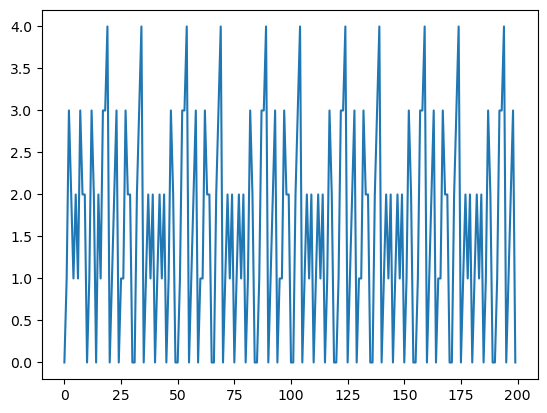

In [10]:
import matplotlib.pyplot as plt

height_diffs = solve_part2(rocks, rock_widths, parse_input("test_jet_pattern"))
plt.plot(height_diffs[:200])

Yup. There's a cycle/pattern!

In [11]:
import re

In [12]:
def really_solve_part2(height_diffs):
    num_rocks = 1e12
    height_diffs_str = "".join(map(str, height_diffs))

    regex = re.compile(r"(.+)(\1)+")  # Finds a duplicate in the string!
    matches = regex.findall(height_diffs_str)

    # Take the duplicate that is the longest length
    max_cycle_length = 0
    for match in matches:
        if len(match[0]) > max_cycle_length:
            cycle = match[0]
            max_cycle_length = len(cycle)

    # print(cycle)

    # Calc the sums of the height diffs and multiply where needed to simulatin 1 trillion rocks!
    cycle_start = height_diffs_str.index(cycle)
    first_sum = sum(height_diffs[:cycle_start])
    cycle_sum = sum(height_diffs[cycle_start:cycle_start+max_cycle_length])
    num_cycles = int((num_rocks - cycle_start) // max_cycle_length)
    remainder = int((num_rocks - cycle_start) % max_cycle_length)
    last_sum = sum(height_diffs[cycle_start:cycle_start+remainder+1])

    return int(first_sum + cycle_sum * num_cycles + last_sum)


### Run on Test Data

In [13]:
really_solve_part2(solve_part2(rocks, rock_widths, parse_input("test_jet_pattern"))) == 1514285714288

True

### Run on Input Data

In [14]:
really_solve_part2(solve_part2(rocks, rock_widths, parse_input("jet_pattern")))

1200000000014

Need to increase the number of rocks initially simulated to find a larger cycle...

In [15]:
really_solve_part2(solve_part2(rocks, rock_widths, parse_input("jet_pattern"), num_rocks=40000))

1591977077342